In [20]:
# 1) Importar la clase principal para perfiles de luz
from lenstronomy.LightModel.light_model import LightModel
import numpy as np
from lenstronomy.Util.param_util import phi_q2_ellipticity

# ————————————————————————————————
# PARTE A: Luz de la FUENTE (host estelar + quásar punctual)
# Según el paper, el host tiene Rₑ≈0.15" y un Sérsic casi exponencial.

# 2) Perfil Sérsic circular para la luz extendida del host
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)

# Centramos la fuente en (0,0) en el plano fuente
beta_ra, beta_dec = 0.0, 0.0  

kwargs_light_source = [{
    'amp':       1.0,    # brillo arbitrario, ajustable luego
    'R_sersic':  0.15,   # radio efectivo ≃0.15" (≈1.2 kpc a z≈2)
    'n_sersic':  1.0,    # perfil casi exponencial
    'center_x':  beta_ra,
    'center_y':  beta_dec
}]

# 3) Si quieres incluir el quásar puntual en el plano fuente,
#    basta dibujarlo luego con PSF o marcar (0,0). No usaremos PointSource aquí
#    porque queremos ver solo su delta en (0,0).

# ————————————————————————————————
# PARTE B: Luz de la LENTE (galaxia deflectora)
# Elegimos un Sérsic elíptico con parámetros típicos (ajustables).

lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)

# Extraemos e1, e2 a partir del ángulo mayor y axis–ratio del paper:
phi_lens = np.deg2rad(-22.29)  # eje mayor a –22.29° (E→N)
q_lens   = 0.866               # minor/major axis ratio
e1_lens, e2_lens = phi_q2_ellipticity(phi=phi_lens, q=q_lens)

kwargs_light_lens = [{
    'amp':       500.0,        # normalización (ajústala para que la lente sea visible)
    'R_sersic':  0.8,          # radio efectivo ≃0.8" –1" para la galaxia deflectora
    'n_sersic':  3.5,          # perfil más concentrado que el host
    'e1':        e1_lens,
    'e2':        e2_lens,
    'center_x':  0.0,          # centrada en el origen de la rejilla
    'center_y':  0.0
}]

# 4) Para visualizar solo la luz de la lente en el plano imagen:
#    necesitas primero una rejilla (x_grid, y_grid) de PixelGrid;
#    suponiendo que ya la tienes creada:
#
#    x_grid, y_grid = pixel_grid.pixel_coordinates
#
#    entonces:
#    flux_lens = lightModel_lens.surface_brightness(x_grid, y_grid, kwargs_light_lens)
#
#    y lo muestras con:
#
#    import matplotlib.pyplot as plt
#    plt.imshow(flux_lens, origin='lower', extent=[...])
#    plt.colorbar(label='counts / arcsec²')
#    plt.title('Luz de la lente (Sérsic elíptico)')
#    plt.show()


In [21]:
# --- LENS MODEL: PERFIL GLOBAL + SUBHALO + SHEAR (según Vegetti+2012) ---

# 1) Imports básicos
import numpy as np
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util #ayuda a definir las cosas para los modelos paramétricos de brillo}

# 2) Cosmología y redshifts del sistema
z_lens, z_source = 0.881, 2.059
cosmo      = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# 3) Distancias angulares necesarias
D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

# 4) Parámetros de la lente principal (EPL)
theta_E_main = 0.452                 # radio de Einstein [arcsec]
gamma_main   = 2.042                 # pendiente de densidad
phi_main     = np.deg2rad(-22.29)    # posición de eje mayor (rad)
q_main       = 0.866                 # axis ratio
e1_main, e2_main = param_util.phi_q2_ellipticity(phi=phi_main, q=q_main)
kwargs_main = {
    'theta_E':  theta_E_main,
    'gamma':    gamma_main,
    'e1':       e1_main,
    'e2':       e2_main,
    'center_x': 0.0,
    'center_y': 0.0
}

# 5) Subhalo como SIS: calcular θ_E a partir de M_sub
M_sub = 1.9e8 * u.M_sun  # masa del satélite
# fórmula SIS: θ_E^2 = (4GM/c^2) * (D_ds/(D_d D_s))
thetaE_sub_rad = np.sqrt(4 * G * M_sub / c**2 * (D_ds/(D_d * D_s)))
# interpretamos el resultado como ángulo en radianes y pasamos a arcsec
thetaE_sub = (thetaE_sub_rad * u.rad).to(u.arcsec).value

# datos de posición del subhalo (según el paper)
x_sub, y_sub = 0.036, 0.576  # [arcsec]

kwargs_sub = {
    'theta_E':  thetaE_sub,
    'center_x': x_sub,
    'center_y': y_sub
}

# 6) Cizalladura externa reducida (SHEAR_REDUCED)
gamma_ext = 0.015
psi_ext   = np.deg2rad(107.9)
g1, g2    = shear_polar2cartesian(phi=psi_ext, gamma=gamma_ext)

kwargs_shear = {'gamma1': g1, 'gamma2': g2}

# 7) Instanciar LensModel y empaquetar parámetros
lens_model_list = ['EPL', 'SIS', 'SHEAR_REDUCED']
lensModel      = LensModel(lens_model_list=lens_model_list)
kwargs_lens    = [kwargs_main, kwargs_sub, kwargs_shear]

# Ahora `lensModel` y `kwargs_lens` están listos para usarse en ImageModel.


In [22]:
# 1) Importar la clase que gestiona la correspondencia píxel ↔ ángulo
from lenstronomy.Data.pixel_grid import PixelGrid
import numpy as np

# 2) Tamaño de píxel en tu simulación: 0.05″ por píxel
deltaPix = 0.05  # [arcsec/pixel]

# 3) Coordenadas angulares de la esquina (0,0) de tu imagen
#    Aquí centramos un campo de 100×100 píxeles de lado 5″ (100×0.05″)
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5  # [arcsec]

# 4) Matriz de transformación lineal píxel→ángulo
#    [[ΔRA_x, rot], [rot, ΔDEC_y]]
#    Sin rotación: escalado puro en X y Y
transform_pix2angle = np.eye(2) * deltaPix

# 5) Empaquetar argumentos para PixelGrid
kwargs_pixel = {
    'nx':                   100,               # píxeles en X
    'ny':                   100,               # píxeles en Y
    'ra_at_xy_0':           ra_at_xy_0,        # RA en píxel (0,0)
    'dec_at_xy_0':          dec_at_xy_0,       # DEC en píxel (0,0)
    'transform_pix2angle':  transform_pix2angle # WCS lineal
}

# 6) Crear la rejilla de píxeles
pixel_grid = PixelGrid(**kwargs_pixel)

# 7) Extraer los arrays 2D de coordenadas angulares de cada píxel
#    Ambos de forma (ny, nx)
x_coords, y_coords = pixel_grid.pixel_coordinates

# 8a) Ejemplo de mapeo directo: pasar (RA,DEC) → posición de píxel flotante
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0.0, dec=0.0)

# 8b) Ejemplo de mapeo inverso: pasar índices de píxel → coordenadas angulares
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)


In [23]:
from lenstronomy.Data.psf import PSF

kwargs_psf = {
    'psf_type':   'GAUSSIAN',
    'fwhm':       0.1,       # arcsec
    'pixel_size': deltaPix  # coincida con tu PixelGrid
}
psf = PSF(**kwargs_psf)

from lenstronomy.PointSource.point_source import PointSource

point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel,
    fixed_magnification_list=[True]
)
# tus parámetros del quásar puntual
kwargs_ps = [{
    'ra_source':  beta_ra,
    'dec_source': beta_dec,
    'source_amp': 100
}]



/home/kingsman/Escritorio/Lenstronomy/lensenv/lib/python3.10/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))
/tmp/ipykernel_14157/1936339739.py:46: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image_noisy), origin='lower')


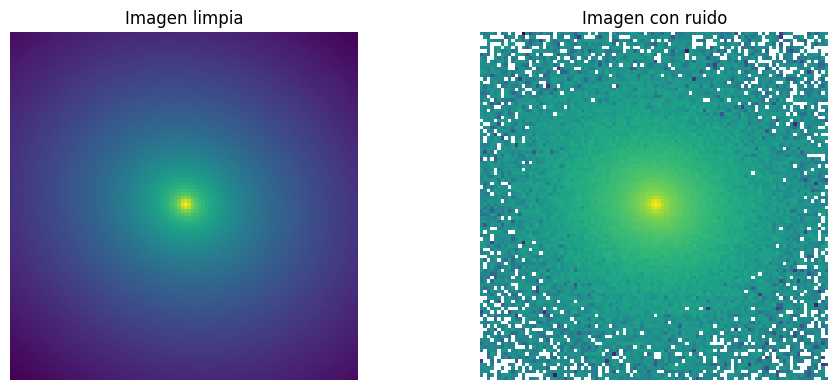

In [24]:
# ————————————————————————————————————————————————
# 6) IMAGEMODEL: ensamblar y simular

from lenstronomy.ImSim.image_model import ImageModel

kwargs_numerics = {
    'supersampling_factor':      1,
    'supersampling_convolution': False
}

imageModel = ImageModel(
    data_class             = pixel_grid,
    psf_class              = psf,
    lens_model_class       = lensModel,
    source_model_class     = lightModel_source,
    lens_light_model_class = lightModel_lens,
    point_source_class     = None,
    kwargs_numerics        = kwargs_numerics
)

# simular imagen limpia (counts por píxel)
image = imageModel.image(
    kwargs_lens       = kwargs_lens,
    kwargs_source     = kwargs_light_source,
    kwargs_lens_light = kwargs_light_lens,
    kwargs_ps         = None
)

# ————————————————————————————————————————————————
# 7) Añadir ruido y visualizar

import lenstronomy.Util.image_util as image_util
import matplotlib.pyplot as plt
import numpy as np

exp_time       = 100   # segundos de exposición
background_rms = 0.1   # counts RMS de fondo

poisson     = image_util.add_poisson(image, exp_time=exp_time)
bkg         = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + poisson + bkg

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(np.log10(image),       origin='lower')
axes[0].set_title('Imagen limpia')
axes[1].imshow(np.log10(image_noisy), origin='lower')
axes[1].set_title('Imagen con ruido')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


/tmp/ipykernel_14157/1015021495.py:169: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy), origin='lower'); axes[1].set_title('Con ruido')


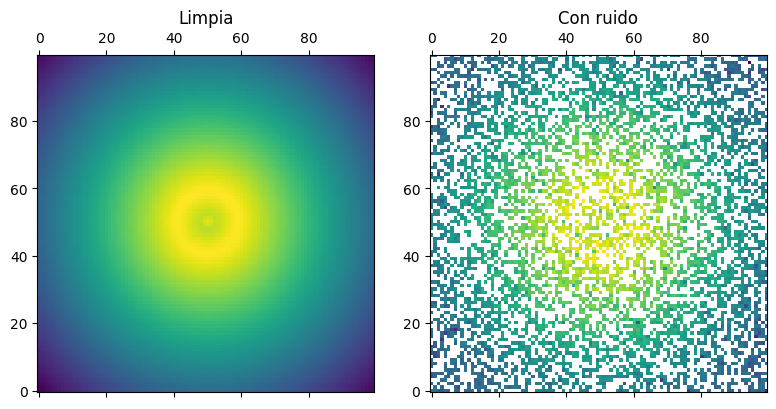

In [25]:
# ————————————————————————————————————————————————
# 0) Imports generales
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM


from lenstronomy.Util.param_util import phi_q2_ellipticity
from lenstronomy.PointSource.point_source import PointSource
import lenstronomy.Util.param_util as param_util  # ayuda a definir las cosas para los modelos paramétricos de brillo

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf        import PSF
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model   import LensModel
from lenstronomy.ImSim.image_model      import ImageModel
import lenstronomy.Util.image_util      as image_util
#from lenstronomy.Util.param_util       import phi_q2ellipticity, shear_polar2cartesian
from lenstronomy.Util.param_util       import shear_polar2cartesian
from lenstronomy.Cosmo.lens_cosmo      import LensCosmo

# ————————————————————————————————————————————————
# 1) COSMOLOGÍA y distancias
z_lens, z_source = 0.881, 2.059
cosmo      = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

# ————————————————————————————————————————————————
# 2) PIXELGRID (5″ × 5″ a 0.05″/pix)
deltaPix = 0.05  # arcsec/pixel
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5
transform_pix2angle = np.eye(2) * deltaPix

kwargs_pixel = {
    'nx': 100, 'ny': 100,
    'ra_at_xy_0':  ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle
}
pixel_grid = PixelGrid(**kwargs_pixel)
x_coords, y_coords = pixel_grid.pixel_coordinates

# ————————————————————————————————————————————————
# 3) PSF (gaussiano, FWHM = 0.1″)
kwargs_psf = {'psf_type':'GAUSSIAN','fwhm':0.1,'pixel_size':deltaPix}
psf = PSF(**kwargs_psf)

# ————————————————————————————————————————————————
# 4) LIGHTMODEL: FUENTE + LENTE
#    A) FUENTE extendida (Sérsic circular)
lightModel_source = LightModel(light_model_list=['SERSIC'])
kwargs_light_source = [{
    'amp':      100.0,
    'R_sersic': 0.15,
    'n_sersic': 1.0,
    'center_x': 0.0,
    'center_y': 0.0
}]

# A) FUENTE extendida “mejorada” (Sérsic + clump gaussiano)
# from lenstronomy.LightModel.light_model import LightModel
# import numpy as np

# # Ahora combinamos un Sérsic para la distribución general 
# # y un pequeño Gaussiano para simular la asimetría/clump que se ve en el paper.
# lightModel_source = LightModel(
#     light_model_list=['SERSIC', 'GAUSSIAN_ELLIPSE']
# )

# kwargs_light_source = [
#     # 1) Componente Sérsic “host” suave
#     {
#         'amp':       100,    # brillo total (ajustable)
#         'R_sersic':  0.1,   # radio efectivo ≃0.15"
#         'n_sersic':  1.5,    # casi exponencial
#         'center_x':  0.0,    # centrada en el origen
#         'center_y':  0.0
#     },
#     # 2) Componente Gaussiana pequeña/clump
#     {
#         'amp':       100,    # relativa al host
#         'sigma':     0.03,   # ancho ≃0.03"
#         'e1':        0.0,    # gaussiana circular
#         'e2':        0.0,
#         'center_x':  0.1,    # desplazada 0.1" en X
#         'center_y': -0.1     # desplazada -0.1" en Y
#     }
# ]


# #Fuente puntual (quásar) no se modela aquí, pero si quieres incluirlo,
# pointSource = PointSource(['SOURCE_POSITION'], lensModel, [True])
# kwargs_ps = [{'ra_source':0, 'dec_source':0, 'source_amp':100}]
# # luego en ImageModel pasa point_source_class=pointSource y kwargs_ps=kwargs_ps


#    B) LUZ de la LENTE (Sérsic elíptico)
lightModel_lens = LightModel(light_model_list=['SERSIC_ELLIPSE'])
phi_lens, q_lens = np.deg2rad(-22.29), 0.866
e1_lens, e2_lens = param_util.phi_q2_ellipticity(phi=phi_lens, q=q_lens)
kwargs_light_lens = [{
    'amp':      0.0,
    'R_sersic': 0.8,
    'n_sersic': 3.5,
    'e1':       e1_lens,
    'e2':       e2_lens,
    'center_x': 0.0,
    'center_y': 0.0
}]

# ————————————————————————————————————————————————
# 5) LENSMODEL: EPL + SIS(subhalo) + SHEAR_REDUCED
#    a) EPL (perfil global)
theta_E_main, gamma_main = 0.452, 2.042
e1_main, e2_main = param_util.phi_q2_ellipticity(phi=np.deg2rad(-22.29), q=0.866)
kwargs_main = {
    'theta_E': theta_E_main, 'gamma': gamma_main,
    'e1': e1_main, 'e2': e2_main,
    'center_x':0.0,'center_y':0.0
}
#    b) SIS subhalo (masa = 1.9e8 M⊙)
M_sub = 1.9e8 * u.M_sun
thetaE_sub_rad = np.sqrt(4*G*M_sub/c**2 * (D_ds/(D_d*D_s)))
thetaE_sub     = (thetaE_sub_rad * u.rad).to(u.arcsec).value
kwargs_sub = {'theta_E':thetaE_sub,'center_x':0.036,'center_y':0.576}
#    c) shear externo
g1, g2 = shear_polar2cartesian(phi=np.deg2rad(107.9), gamma=0.015)
kwargs_shear = {'gamma1':g1,'gamma2':g2}

lens_model_list = ['EPL','SIS','SHEAR_REDUCED']
lensModel       = LensModel(lens_model_list=lens_model_list)
kwargs_lens     = [kwargs_main, kwargs_sub, kwargs_shear]

# ————————————————————————————————————————————————
# 6) IMAGEMODEL: ensamblar y simular
kwargs_numerics = {'supersampling_factor':1,'supersampling_convolution':False}
imageModel = ImageModel(
    data_class             = pixel_grid,
    psf_class              = psf,
    lens_model_class       = lensModel,
    source_model_class     = lightModel_source,
    lens_light_model_class = lightModel_lens,
    point_source_class     = None,  # No usamos quásares puntuales aquí
    kwargs_numerics        = kwargs_numerics
)

image = imageModel.image(
    kwargs_lens       = kwargs_lens,
    kwargs_source     = kwargs_light_source,
    kwargs_lens_light = kwargs_light_lens,
    kwargs_ps         = None
)

# ————————————————————————————————————————————————
# 7) Añadir ruido y visualizar
exp_time, background_rms = 0.0001, 0.0001
poisson    = image_util.add_poisson(image, exp_time=exp_time)
bkg        = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + poisson + bkg

f, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].matshow(np.log10(image),       origin='lower'); axes[0].set_title('Limpia')
axes[1].matshow(np.log10(image_noisy), origin='lower'); axes[1].set_title('Con ruido')
plt.tight_layout()
plt.show()


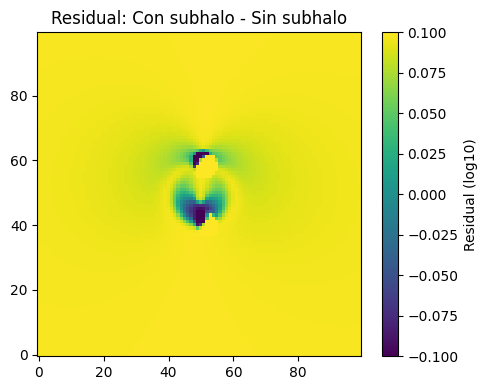

In [26]:
import numpy as np

# Calcular y mostrar el residual (diferencia logarítmica) entre ambas imágenes
import matplotlib.pyplot as plt

residual = np.log10(image_sub) - np.log10(image_nosub)

plt.figure(figsize=(5, 4))
plt.imshow(residual, origin='lower', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Residual (log10)')
plt.title('Residual: Con subhalo - Sin subhalo')
#plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_14157/3587619372.py:170: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy), origin='lower', cmap='inferno'); axes[1].set_title('Con ruido')


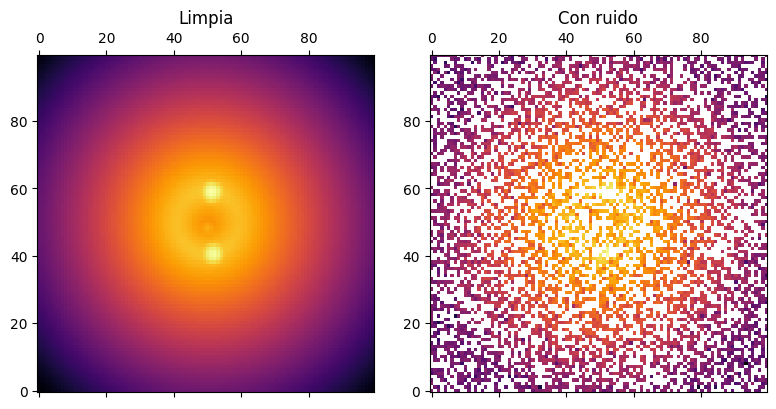

In [27]:
# 1) COSMOLOGÍA y distancias
z_lens, z_source = 0.881, 2.059
cosmo      = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

# ————————————————————————————————————————————————
# 2) PIXELGRID (5″ × 5″ a 0.05″/pix)
deltaPix = 0.05  # arcsec/pixel
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5
transform_pix2angle = np.eye(2) * deltaPix

kwargs_pixel = {
    'nx': 100, 'ny': 100,
    'ra_at_xy_0':  ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle
}
pixel_grid = PixelGrid(**kwargs_pixel)
x_coords, y_coords = pixel_grid.pixel_coordinates

# ————————————————————————————————————————————————
# 3) PSF (gaussiano, FWHM = 0.1″)
kwargs_psf = {'psf_type':'GAUSSIAN','fwhm':0.1,'pixel_size':deltaPix}
psf = PSF(**kwargs_psf)

# ————————————————————————————————————————————————
# 4) LIGHTMODEL: FUENTE + LENTE
#    A) FUENTE extendida (Sérsic circular)
lightModel_source = LightModel(light_model_list=['SERSIC'])
kwargs_light_source = [{
    'amp':      10.0,
    'R_sersic': 0.15,
    'n_sersic': 1.0,
    'center_x': 0.0,
    'center_y': 0.0
}]

# A) FUENTE extendida “mejorada” (Sérsic + clump gaussiano)
# from lenstronomy.LightModel.light_model import LightModel
# import numpy as np

# # Ahora combinamos un Sérsic para la distribución general 
# # y un pequeño Gaussiano para simular la asimetría/clump que se ve en el paper.
# lightModel_source = LightModel(
#     light_model_list=['SERSIC', 'GAUSSIAN_ELLIPSE']
# )

# kwargs_light_source = [
#     # 1) Componente Sérsic “host” suave
#     {
#         'amp':       100,    # brillo total (ajustable)
#         'R_sersic':  0.1,   # radio efectivo ≃0.15"
#         'n_sersic':  1.5,    # casi exponencial
#         'center_x':  0.0,    # centrada en el origen
#         'center_y':  0.0
#     },
#     # 2) Componente Gaussiana pequeña/clump
#     {
#         'amp':       100,    # relativa al host
#         'sigma':     0.03,   # ancho ≃0.03"
#         'e1':        0.0,    # gaussiana circular
#         'e2':        0.0,
#         'center_x':  0.1,    # desplazada 0.1" en X
#         'center_y': -0.1     # desplazada -0.1" en Y
#     }
# ]


# #Fuente puntual (quásar) no se modela aquí, pero si quieres incluirlo,
# pointSource = PointSource(['SOURCE_POSITION'], lensModel, [True])
# kwargs_ps = [{'ra_source':0, 'dec_source':0, 'source_amp':100}]
# # luego en ImageModel pasa point_source_class=pointSource y kwargs_ps=kwargs_ps


#    B) LUZ de la LENTE (Sérsic elíptico)
lightModel_lens = LightModel(light_model_list=['SERSIC_ELLIPSE'])
phi_lens, q_lens = np.deg2rad(-22.29), 0.866
e1_lens, e2_lens = param_util.phi_q2_ellipticity(phi=phi_lens, q=q_lens)
kwargs_light_lens = [{
    'amp':      0.0,
    'R_sersic': 0.8,
    'n_sersic': 3.5,
    'e1':       e1_lens,
    'e2':       e2_lens,
    'center_x': 0.0,
    'center_y': 0.0
}]

# ————————————————————————————————————————————————
# 5) LENSMODEL: EPL + SIS(subhalo) + SHEAR_REDUCED
#    a) EPL (perfil global)
theta_E_main, gamma_main = 0.452, 2.042
e1_main, e2_main = param_util.phi_q2_ellipticity(phi=np.deg2rad(-22.29), q=0.866)
kwargs_main = {
    'theta_E': theta_E_main, 'gamma': gamma_main,
    'e1': e1_main, 'e2': e2_main,
    'center_x':0.0,'center_y':-0.1
}
#    b) SIS subhalo (masa = 1.9e8 M⊙)
M_sub = 1.9e8 * u.M_sun
thetaE_sub_rad = np.sqrt(4*G*M_sub/c**2 * (D_ds/(D_d*D_s)))
thetaE_sub     = (thetaE_sub_rad * u.rad).to(u.arcsec).value
kwargs_sub = {'theta_E':thetaE_sub,'center_x':0.036,'center_y':0.576}
#    c) shear externo
g1, g2 = shear_polar2cartesian(phi=np.deg2rad(107.9), gamma=0.015)
kwargs_shear = {'gamma1':g1,'gamma2':g2}

lens_model_list = ['EPL','SIS','SHEAR_REDUCED']
lensModel       = LensModel(lens_model_list=lens_model_list)
kwargs_lens     = [kwargs_main, kwargs_sub, kwargs_shear]

# ————————————————————————————————————————————————
# 5b) POINT SOURCE: quásar puntual en el plano fuente

from lenstronomy.PointSource.point_source import PointSource

# 1) Definir el tipo de fuente puntual: posición en el plano fuente
point_source_model_list = ['SOURCE_POSITION']

# 2) Instanciar PointSource indicando el LensModel y que la magnificación es fija
pointSource = PointSource(
    point_source_type_list    = point_source_model_list,
    lens_model                = lensModel,
    fixed_magnification_list  = [True]
)

# 3) Parámetros del quásar puntual
#    aquí lo centramos en (0,0) con amplitud 100 counts
kwargs_ps = [{
    #'amp':       1000.0,  # amplitud relativa al brillo de la fuente extendida
    'ra_source':  0.0,
    'dec_source': 0.0,
    'source_amp': 10.0
}]


# ————————————————————————————————————————————————
# 6) IMAGEMODEL: ensamblar y simular incluyendo el punto

imageModel = ImageModel(
    data_class             = pixel_grid,
    psf_class              = psf,
    lens_model_class       = lensModel,
    source_model_class     = lightModel_source,
    lens_light_model_class = lightModel_lens,
    point_source_class     = pointSource,      # <— ahora incluimos el puntual
    kwargs_numerics        = kwargs_numerics
)

image_with_ps = imageModel.image(
    kwargs_lens       = kwargs_lens,
    kwargs_source     = kwargs_light_source,
    kwargs_lens_light = kwargs_light_lens,
    kwargs_ps         = kwargs_ps           # <— aquí pasamos los parámetros del quásar
)

# ————————————————————————————————————————————————
# 7) Añadir ruido y visualizar
exp_time, background_rms = 0.0001, 0.0001
poisson    = image_util.add_poisson(image_with_ps, exp_time=exp_time)
bkg        = image_util.add_background(image_with_ps, sigma_bkd=background_rms)
image_noisy = image_with_ps + poisson + bkg

f, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].matshow(np.log10(image_with_ps),       origin='lower', cmap='inferno'); axes[0].set_title('Limpia')
axes[1].matshow(np.log10(image_noisy), origin='lower', cmap='inferno'); axes[1].set_title('Con ruido')
plt.tight_layout()
plt.show()


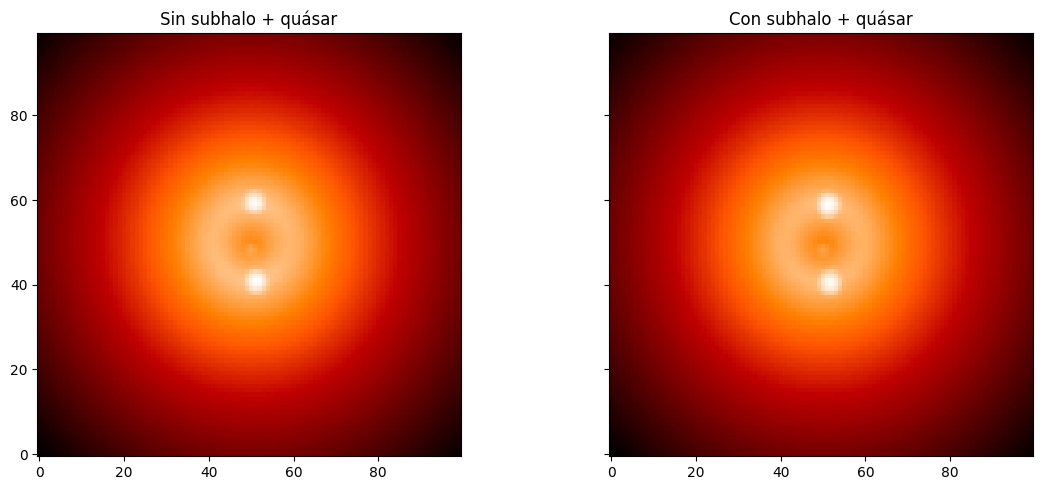

In [31]:
# ————————————————————————————————————————————————
# 8) Simular y comparar: SIN vs. CON subhalo (con quásar puntual)

# a) Modelo SIN subhalo (EPL + SHEAR_REDUCED + quásar puntual)
lens_model_list_nosub = ['EPL', 'SHEAR_REDUCED']
lensModel_nosub       = LensModel(lens_model_list=lens_model_list_nosub)
kwargs_lens_nosub     = [kwargs_main, kwargs_shear]

# Crear un PointSource separado para el modelo sin subhalo
pointSource_nosub = PointSource(
    point_source_type_list = point_source_model_list,
    lens_model             = lensModel_nosub,
    fixed_magnification_list = [True]
)

imageModel_nosub = ImageModel(
    data_class             = pixel_grid,
    psf_class              = psf,
    lens_model_class       = lensModel_nosub,
    source_model_class     = lightModel_source,
    lens_light_model_class = lightModel_lens,
    point_source_class     = pointSource_nosub,    # <— usar el nuevo pointSource
    kwargs_numerics        = kwargs_numerics
)
image_nosub = imageModel_nosub.image(
    kwargs_lens       = kwargs_lens_nosub,
    kwargs_source     = kwargs_light_source,
    kwargs_lens_light = kwargs_light_lens,
    kwargs_ps         = kwargs_ps           # <— OBLIGATORIO si hay pointSource
)


# # b) Modelo CON subhalo (EPL + SIS + SHEAR_REDUCED + quásar puntual)
# imageModel_sub = ImageModel(
#     data_class             = pixel_grid,
#     psf_class              = psf,
#     lens_model_class       = lensModel,
#     source_model_class     = lightModel_source,
#     lens_light_model_class = lightModel_lens,
#     point_source_class     = pointSource,
#     kwargs_numerics        = kwargs_numerics
# )
# image_sub = imageModel_sub.image(
#     kwargs_lens       = kwargs_lens,
#     kwargs_source     = kwargs_light_source,
#     kwargs_lens_light = kwargs_light_lens,
#     kwargs_ps         = kwargs_ps
# )

# c) Visualizar lado a lado
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
axes[0].imshow(np.log10(image_nosub), origin='lower', cmap='gist_heat')
axes[0].set_title('Sin subhalo + quásar')
axes[1].imshow(np.log10(image_with_ps), origin='lower', cmap='gist_heat')
axes[1].set_title('Con subhalo + quásar')
# for ax in axes:
#     ax.axis('off')
plt.tight_layout()
plt.show()


/tmp/ipykernel_18838/1110280702.py:156: RuntimeWarning: invalid value encountered in log10
  im0 = axes[0].imshow(np.log10(image_sub_noisy), origin='lower', cmap='gist_heat',


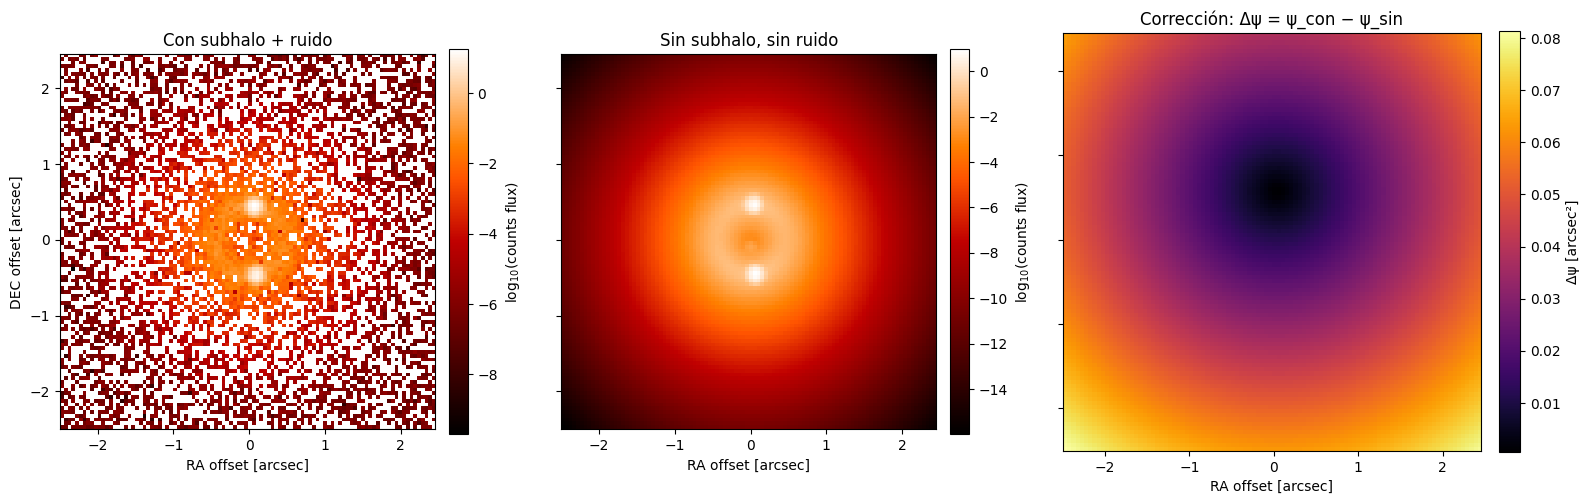

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dependencias de lenstronomy y astropy ---
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util

# --- Parámetros cosmológicos y distancias ---
z_lens, z_source = 0.881, 2.059
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

# --- PixelGrid ---
deltaPix = 0.05
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5
transform_pix2angle = np.eye(2) * deltaPix
kwargs_pixel = {
    'nx': 100, 'ny': 100,
    'ra_at_xy_0': ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle
}
pixel_grid = PixelGrid(**kwargs_pixel)
x_coords, y_coords = pixel_grid.pixel_coordinates

# --- PSF ---
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1, 'pixel_size': deltaPix}
psf = PSF(**kwargs_psf)

# --- Modelos de luz ---
lightModel_source = LightModel(light_model_list=['SERSIC'])
kwargs_light_source = [{
    'amp': 10.0,
    'R_sersic': 0.15,
    'n_sersic': 1.0,
    'center_x': 0.0,
    'center_y': 0.0
}]

# --- Parámetros de la lente ---
# Parámetros de la lente principal (Sersic)
phi_lens, q_lens = np.deg2rad(-22.29), 0.866
e1_lens, e2_lens = phi_q2_ellipticity(phi=phi_lens, q=q_lens)
lightModel_lens = LightModel(light_model_list=['SERSIC_ELLIPSE'])
kwargs_light_lens = [{
    'amp': 0.0,
    'R_sersic': 0.8,
    'n_sersic': 3.5,
    'e1': e1_lens,
    'e2': e2_lens,
    'center_x': 0.0,
    'center_y': 0.0
}]

# --- Modelos de lente ---
theta_E_main, gamma_main = 0.452, 2.042
e1_main, e2_main = phi_q2_ellipticity(phi=np.deg2rad(-22.29), q=0.866)
kwargs_main = {
    'theta_E': theta_E_main, 'gamma': gamma_main,
    'e1': e1_main, 'e2': e2_main,
    'center_x': 0.0, 'center_y': -0.1
}
M_sub = 1.9e8 * u.M_sun
thetaE_sub_rad = np.sqrt(4*G*M_sub/c**2 * (D_ds/(D_d*D_s)))
thetaE_sub = (thetaE_sub_rad * u.rad).to(u.arcsec).value
kwargs_sub = {'theta_E': thetaE_sub, 'center_x': 0.036, 'center_y': 0.576}
g1, g2 = shear_polar2cartesian(phi=np.deg2rad(107.9), gamma=0.015)
kwargs_shear = {'gamma1': g1, 'gamma2': g2}

lens_model_list = ['EPL', 'SIS', 'SHEAR_REDUCED']
lensModel = LensModel(lens_model_list=lens_model_list)
kwargs_lens = [kwargs_main, kwargs_sub, kwargs_shear]

lens_model_list_nosub = ['EPL', 'SHEAR_REDUCED']
lensModel_nosub = LensModel(lens_model_list=lens_model_list_nosub)
kwargs_lens_nosub = [kwargs_main, kwargs_shear]

# --- Fuente puntual (quásar) ---
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel,
    fixed_magnification_list=[True]
)
kwargs_ps = [{
    'ra_source': 0.0,
    'dec_source': 0.0,
    'source_amp': 10.0
}]
pointSource_nosub = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel_nosub,
    fixed_magnification_list=[True]
)

# --- Numerics ---
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# --- ImageModel con subhalo ---
imageModel = ImageModel(
    data_class=pixel_grid,
    psf_class=psf,
    lens_model_class=lensModel,
    source_model_class=lightModel_source,
    lens_light_model_class=lightModel_lens,
    point_source_class=pointSource,
    kwargs_numerics=kwargs_numerics
)

# --- ImageModel sin subhalo ---
imageModel_nosub = ImageModel(
    data_class=pixel_grid,
    psf_class=psf,
    lens_model_class=lensModel_nosub,
    source_model_class=lightModel_source,
    lens_light_model_class=lightModel_lens,
    point_source_class=pointSource_nosub,
    kwargs_numerics=kwargs_numerics
)

# --- Simulación de imágenes ---
exp_time = 100  # Tiempo de exposición en segundos
background_rms = 1e-6  # RMS del fondo en unidades de cuenta

# a) Imagen CON subhalo y CON ruido
image_sub = imageModel.image(
    kwargs_lens=kwargs_lens,
    kwargs_source=kwargs_light_source,
    kwargs_lens_light=kwargs_light_lens,
    kwargs_ps=kwargs_ps
)
poisson_sub = image_util.add_poisson(image_sub, exp_time=exp_time)
bkg_sub = image_util.add_background(image_sub, sigma_bkd=background_rms)
image_sub_noisy = image_sub + poisson_sub + bkg_sub

# b) Imagen SIN subhalo y SIN ruido
image_nosub_clean = imageModel_nosub.image(
    kwargs_lens=kwargs_lens_nosub,
    kwargs_source=kwargs_light_source,
    kwargs_lens_light=kwargs_light_lens,
    kwargs_ps=kwargs_ps
)

# --- Visualización lado a lado con ejes en arcsec y barra de color individual ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

im0 = axes[0].imshow(np.log10(image_sub_noisy), origin='lower', cmap='gist_heat',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[0].set_title('Con subhalo + ruido')
axes[0].set_xlabel('RA offset [arcsec]')
axes[0].set_ylabel('DEC offset [arcsec]')
cbar0 = fig.colorbar(im0, ax=axes[0], shrink=0.85, pad=0.03)
cbar0.set_label('log$_{10}$(counts flux)')

im1 = axes[1].imshow(np.log10(image_nosub_clean), origin='lower', cmap='gist_heat',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[1].set_title('Sin subhalo, sin ruido')
axes[1].set_xlabel('RA offset [arcsec]')
cbar1 = fig.colorbar(im1, ax=axes[1], shrink=0.85, pad=0.03)
cbar1.set_label('log$_{10}$(counts flux)')


# Aplanar las coordenadas para pasar al método de lenstronomy
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()

# El método 'potential' devuelve el potencial en cada punto (x, y)
psi_nosub = lensModel_nosub.potential(x_flat, y_flat, kwargs_lens_nosub)
psi_nosub_map = psi_nosub.reshape(x_coords.shape)
# Calcular el potencial lenteado para el modelo CON subhalo
psi_sub = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi_sub_map = psi_sub.reshape(x_coords.shape)

# Calcular la diferencia (corrección) entre ambos potenciales
delta_psi_map = psi_sub_map - psi_nosub_map

im2 = axes[2].imshow(delta_psi_map, origin='lower', cmap='inferno',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[2].set_title('Corrección: Δψ = ψ_con − ψ_sin')
axes[2].set_xlabel('RA offset [arcsec]')
cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label='Δψ [arcsec²]')

plt.tight_layout()
plt.show()


In [1]:
def simulate_forward(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, noise_level):
    """
    Devuelve (image_noisy, image_smooth, delta_psi_map).
    Simula imágenes con y sin subhalo, añade ruido y calcula el mapa de diferencia de potencial.
    """
    # --- ImageModel con subhalo ---
    imageModel = ImageModel(
        data_class=pixel_grid,
        psf_class=psf,
        lens_model_class=lensModel,
        source_model_class=lightModel_source,
        lens_light_model_class=lightModel_lens,
        point_source_class=pointSource,
        kwargs_numerics=kwargs_numerics
    )

    # --- ImageModel sin subhalo ---
    imageModel_nosub = ImageModel(
        data_class=pixel_grid,
        psf_class=psf,
        lens_model_class=lensModel_nosub,
        source_model_class=lightModel_source,
        lens_light_model_class=lightModel_lens,
        point_source_class=pointSource_nosub,
        kwargs_numerics=kwargs_numerics
    )

    # --- Simulación de imágenes ---
    exp_time = 100  # Tiempo de exposición en segundos
    background_rms = noise_level  # RMS del fondo

    # Imagen CON subhalo y CON ruido
    image_sub = imageModel.image(
        kwargs_lens=kwargs_lens,
        kwargs_source=kwargs_source,
        kwargs_lens_light=kwargs_lens_light,
        kwargs_ps=kwargs_ps
    )
    poisson_sub = image_util.add_poisson(image_sub, exp_time=exp_time)
    bkg_sub = image_util.add_background(image_sub, sigma_bkd=background_rms)
    image_noisy = image_sub + poisson_sub + bkg_sub

    # Imagen SIN subhalo y SIN ruido
    image_smooth = imageModel_nosub.image(
        kwargs_lens=kwargs_lens_nosub,
        kwargs_source=kwargs_source,
        kwargs_lens_light=kwargs_lens_light,
        kwargs_ps=kwargs_ps
    )

    # Mapa de diferencia de potencial (ejemplo: diferencia de imágenes)
    delta_psi_map = image_sub - image_smooth

    return image_noisy, image_smooth, delta_psi_map


In [4]:
# Ejemplo de uso de la función simulate_forward

# Ejecutamos la simulación con los parámetros ya definidos en el notebook
image_noisy, image_smooth, delta_psi_map = simulate_forward(
    kwargs_lens, kwargs_light_source, kwargs_light_lens, kwargs_ps, noise_level
)

# Visualizamos los resultados
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

im0 = axes[0].imshow(np.log10(image_noisy + 1e-8), origin='lower', cmap='inferno')
axes[0].set_title('Imagen con subhalo + ruido')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(np.log10(image_smooth + 1e-8), origin='lower', cmap='inferno')
axes[1].set_title('Imagen sin subhalo')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(delta_psi_map, origin='lower', cmap='RdBu')
axes[2].set_title('Diferencia (Con−Sin)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


NameError: name 'kwargs_lens' is not defined

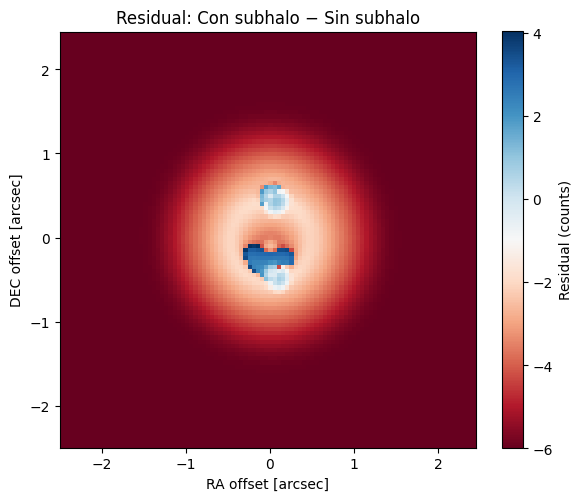

In [47]:
# Calcular el residual entre las dos imágenes anteriores (con y sin subhalo)
residual = image_sub - image_nosub

plt.figure(figsize=(6, 5))
plt.imshow(np.log10(np.abs(residual) + 1e-6)* np.sign(residual), origin='lower', cmap='RdBu', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
plt.colorbar(label='Residual (counts)')
plt.title('Residual: Con subhalo − Sin subhalo')
plt.xlabel('RA offset [arcsec]')
plt.ylabel('DEC offset [arcsec]')
plt.tight_layout()
plt.show()

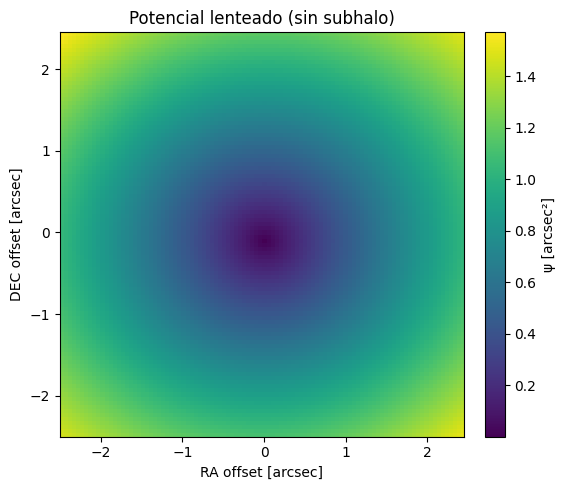

In [35]:
# Calcular el potencial lenteado (potencial de lente) para el modelo SIN subhalo
# Usamos lensModel_nosub y kwargs_lens_nosub ya definidos

# Aplanar las coordenadas para pasar al método de lenstronomy
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()

# El método 'potential' devuelve el potencial en cada punto (x, y)
psi_nosub = lensModel_nosub.potential(x_flat, y_flat, kwargs_lens_nosub)
psi_nosub_map = psi_nosub.reshape(x_coords.shape)

# Visualizar el potencial
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(psi_nosub_map, origin='lower', cmap='viridis',
               extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
ax.set_title('Potencial lenteado (sin subhalo)')
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='ψ [arcsec²]')
plt.tight_layout()
plt.show()

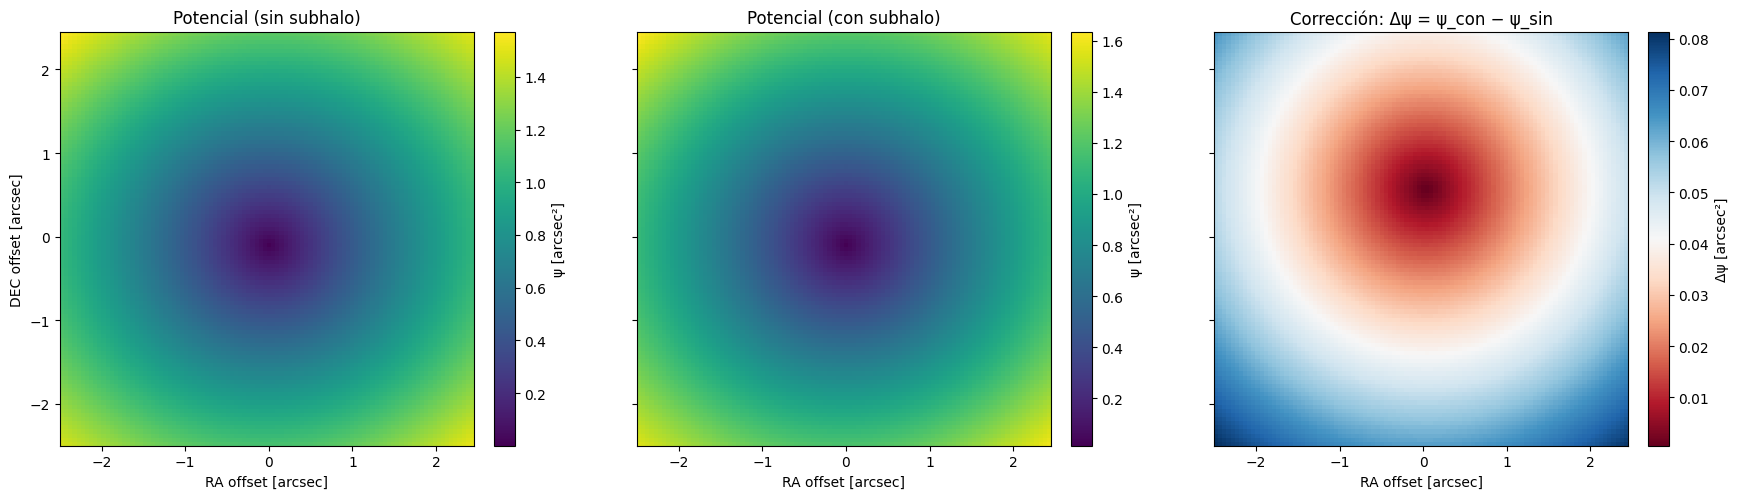

In [36]:
# Calcular el potencial lenteado para el modelo CON subhalo
psi_sub = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi_sub_map = psi_sub.reshape(x_coords.shape)

# Calcular la diferencia (corrección) entre ambos potenciales
delta_psi_map = psi_sub_map - psi_nosub_map

# Visualizar ambos y la corrección
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# 1) Potencial sin subhalo
im0 = axes[0].imshow(psi_nosub_map, origin='lower', cmap='viridis',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[0].set_title('Potencial (sin subhalo)')
axes[0].set_xlabel('RA offset [arcsec]')
axes[0].set_ylabel('DEC offset [arcsec]')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='ψ [arcsec²]')

# 2) Potencial con subhalo
im1 = axes[1].imshow(psi_sub_map, origin='lower', cmap='viridis',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[1].set_title('Potencial (con subhalo)')
axes[1].set_xlabel('RA offset [arcsec]')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label='ψ [arcsec²]')

# 3) Corrección (diferencia)
im2 = axes[2].imshow(delta_psi_map, origin='lower', cmap='RdBu',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[2].set_title('Corrección: Δψ = ψ_con − ψ_sin')
axes[2].set_xlabel('RA offset [arcsec]')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label='Δψ [arcsec²]')

plt.tight_layout()
plt.show()

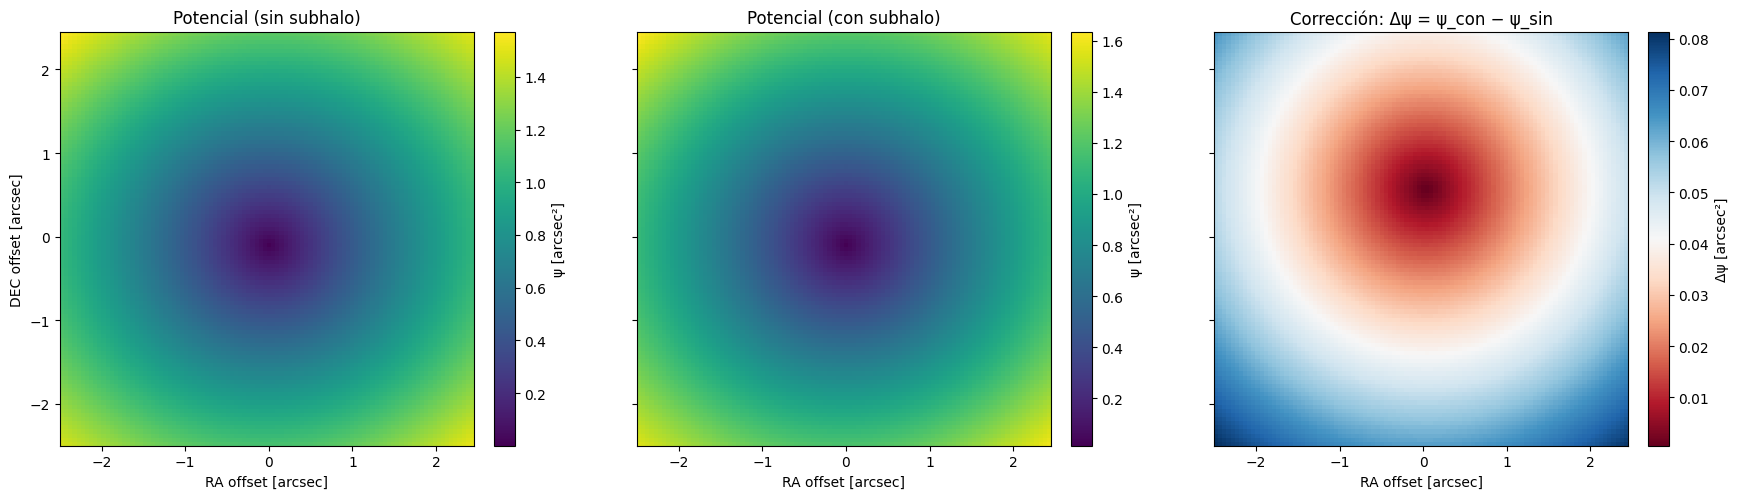

In [18]:
# Calcular el potencial lenteado para el modelo CON subhalo
psi_sub = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi_sub_map = psi_sub.reshape(x_coords.shape)

# Calcular la diferencia (corrección) entre ambos potenciales
delta_psi_map = psi_sub_map - psi_nosub_map

# Visualizar ambos y la corrección
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# 1) Potencial sin subhalo
im0 = axes[0].imshow(psi_nosub_map, origin='lower', cmap='viridis',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[0].set_title('Potencial (sin subhalo)')
axes[0].set_xlabel('RA offset [arcsec]')
axes[0].set_ylabel('DEC offset [arcsec]')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='ψ [arcsec²]')

# 2) Potencial con subhalo
im1 = axes[1].imshow(psi_sub_map, origin='lower', cmap='viridis',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[1].set_title('Potencial (con subhalo)')
axes[1].set_xlabel('RA offset [arcsec]')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label='ψ [arcsec²]')

# 3) Corrección (diferencia)
im2 = axes[2].imshow(delta_psi_map, origin='lower', cmap='RdBu',
                     extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
axes[2].set_title('Corrección: Δψ = ψ_con − ψ_sin')
axes[2].set_xlabel('RA offset [arcsec]')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label='Δψ [arcsec²]')

plt.tight_layout()
plt.show()

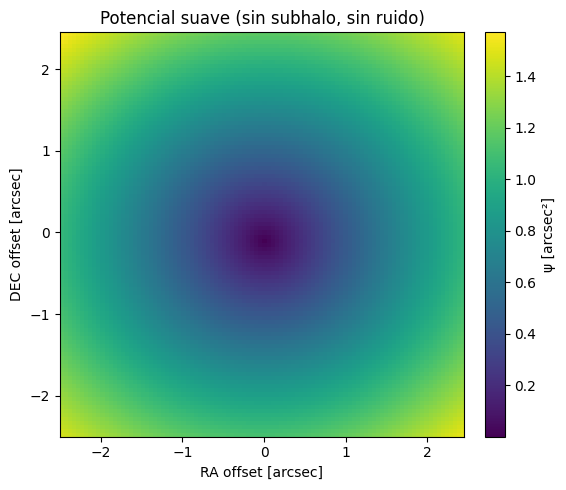

In [37]:
# Visualizar el potencial suave (sin subhalo, sin ruido)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(psi_smooth.reshape(x_coords.shape), origin='lower', cmap='viridis',
               extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
ax.set_title('Potencial suave (sin subhalo, sin ruido)')
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='ψ [arcsec²]')

plt.tight_layout()
plt.show()


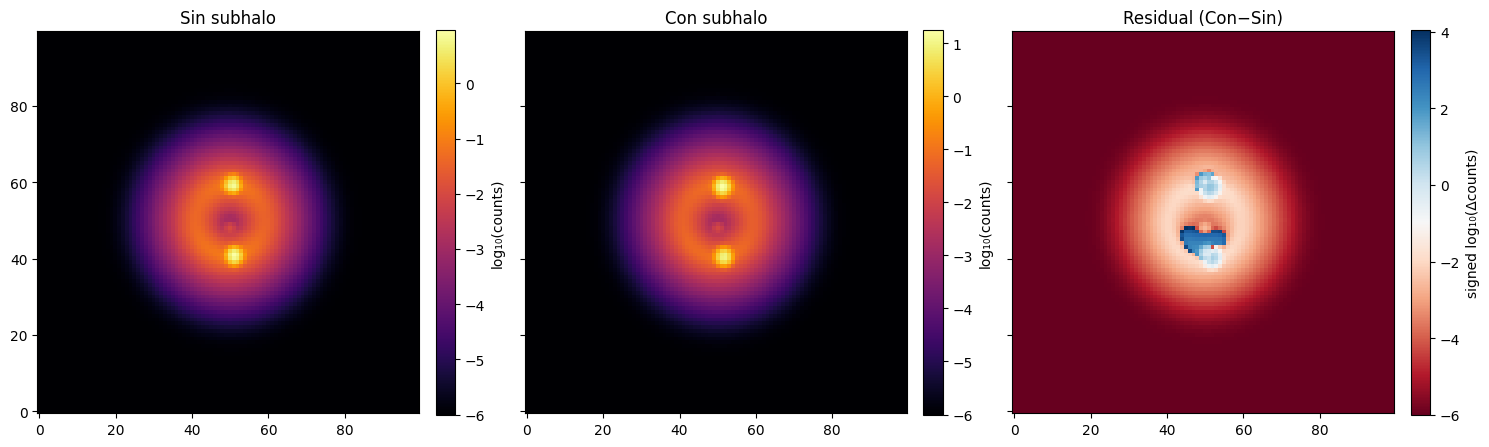

In [38]:
# ————————————————————————————————————————————————
# 8) Comparación: SIN vs CON subhalo (y residual)

import matplotlib.pyplot as plt
import numpy as np

# Calculamos la imagen residual (Con − Sin)
residual = image_with_ps - image_nosub

# Preparamos la figura con tres paneles
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

# 1) Sin subhalo
im0 = axes[0].imshow(np.log10(image_nosub + 1e-6), origin='lower', cmap='inferno')
axes[0].set_title('Sin subhalo')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='log₁₀(counts)')

# 2) Con subhalo
im1 = axes[1].imshow(np.log10(image_with_ps + 1e-6), origin='lower', cmap='inferno')
axes[1].set_title('Con subhalo')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label='log₁₀(counts)')

# 3) Residual (Con − Sin)
im2 = axes[2].imshow(np.log10(np.abs(residual) + 1e-6) * np.sign(residual),
                     origin='lower', cmap='RdBu')
axes[2].set_title('Residual (Con−Sin)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label='signed log₁₀(Δcounts)')

# for ax in axes:
#     ax.axis('off')

plt.tight_layout()
plt.show()
